#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Get Data (run once)

In [ ]:
# upload kaggle file
from google.colab import files
files.upload()

In [ ]:
# Install kaggle package
!pip install --upgrade --force-reinstall --no-deps kaggle

# Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # set permission

In [ ]:
# Use with option -p to choose the destination
!kaggle datasets download -d imakash3011/customer-personality-analysis -p /content/gdrive/MyDrive/DATASET/CUSTOMER_PERSONALITY

In [ ]:
# Now you can Unzip it!
# !unzip -q <SOURCE-PATH> -d <DESTINATION-PATH>

!unzip -q /content/gdrive/MyDrive/DATASET/CUSTOMER_PERSONALITY/customer-personality-analysis.zip -d /content/gdrive/MyDrive/DATASET/CUSTOMER_PERSONALITY

#Import libraries

In [ ]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

from datetime import datetime

pd.options.display.float_format = "{:.5f}".format
# !pip install shap

#Dataset

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/DATASET/CUSTOMER_PERSONALITY/marketing_campaign.csv',sep = "\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.00000,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.00000,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.00000,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.00000,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.00000,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


#Clean Data

In [ ]:
#check duplicated row
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [ ]:
#Drop columns 'Z_CostContact' and 'Z_Revenue' contains constant value across all the observations 
# => drop these two column because they will not contribute anything in learning process of the model.
df.drop(columns=['Z_CostContact','Z_Revenue'],inplace=True)

In [ ]:
# tính upper n lower whisker của Income
q1_income = df['Income'].quantile(0.25)
q3_income = df['Income'].quantile(0.75)

iqr_income = q3_income - q1_income

lower_income = q1_income - 1.5*iqr_income
upper_income = q3_income + 1.5*iqr_income
print(lower_income)
print(upper_income)

-14525.5
118350.5


In [ ]:
#Create Age of customer Column, since the data is collected within 2 year since 2014 so I'll use that to calculate
age_col = 2014 - df['Year_Birth']
df.insert(2,'Age',age_col)

In [ ]:
# tính upper n lower whisker của Year_Birth
q1_birth = df['Year_Birth'].quantile(0.25)
q3_birth = df['Year_Birth'].quantile(0.75)

iqr_birth = q3_birth - q1_birth

lower_birth = q1_birth - 1.5*iqr_birth
upper_birth = q3_birth + 1.5*iqr_birth
print(lower_birth)
print(upper_birth)

1932.0
2004.0


In [ ]:
# Drop outliers
df.drop(df[df['Year_Birth']<1932].index,axis=0,inplace=True)
df.drop(df[df['Income']>118350].index,axis=0,inplace=True)

#Fill NaN with mean value
df['Income'] = df['Income'].fillna(df['Income'].mean())

#Combine 2 columns Kidhome and Teenhome to only 1 column: Children then drop them. 
df['Children'] = df['Kidhome'] + df['Teenhome']
df.drop(columns=['Kidhome','Teenhome'],inplace=True)

In [ ]:
#Change column Dt_Customer to datetime type
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'],dayfirst=True)
df['Month'] = df['Dt_Customer'].dt.month
df['Year'] = df['Dt_Customer'].dt.year
df['YearMonth'] = df['Dt_Customer'].map(lambda date: 100*date.year + date.month)

In [ ]:
df['Dt_Customer'].min()

Timestamp('2012-07-30 00:00:00')

Dt_Customer data is not full in July 2012 so I'll drop these rows.

In [ ]:
df.drop(df[df['YearMonth']==201207].index,axis=0,inplace=True)

**Features Engineering**

In [ ]:
#Create more columns
df['TotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df ['NumStorePurchases']
df['TotalProducts'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCmp'] = df['AcceptedCmp3']+ df['AcceptedCmp4']+ df['AcceptedCmp5']+ df['AcceptedCmp1']+ df['AcceptedCmp2']

In [ ]:
#Create column if customer accepts at least 1 campaign => 1, otherwise 0
df['AtLeast1Cmp'] = 0
df.loc[df['TotalAcceptedCmp']>0,'AtLeast1Cmp'] = 1

In [ ]:
#Rename Products columns
df = df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

# Alone/YOLO/Absurd is considered single so I'll change them to Single
df['Marital_Status'].replace({'Alone':'Single','YOLO':'Single','Absurd':'Single'},inplace=True)

# Change 2n Cycle to Master
df['Education'].replace({'2n Cycle':'Master'},inplace=True)

In [ ]:
# Divide Income and Age to groups and compute new columns.

#Income group
category_income = pd.cut(df['Income'],bins=[0,35000,51000,68000,115000],labels=['Low Income','Lower Middle','Upper Middle','High Income'])
df.insert(5,'Income Group',category_income)
#Age group
category_age = pd.cut(df['Age'],bins=[0,39,59,99],labels=['Young Adult','Middle Aged','Old Adult'])
df.insert(2,'Age Group',category_age)

In [ ]:
#Drop unsused columns
df.drop(columns=['ID','Year_Birth','Dt_Customer'],inplace=True)

In [ ]:
df.head()

,Age Group,Age,Education,Marital_Status,Income Group,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Children,Month,Year,YearMonth,TotalPurchases,TotalProducts,TotalAcceptedCmp,AtLeast1Cmp
0,Middle Aged,57,Graduation,Single,Upper Middle,58138.00000,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0,9,2012,201209,22,1617,0,0
1,Old Adult,60,Graduation,Single,Lower Middle,46344.00000,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2,3,2014,201403,4,27,0,0
2,Middle Aged,49,Graduation,Together,High Income,71613.00000,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,8,2013,201308,20,776,0,0
3,Young Adult,30,Graduation,Together,Low Income,26646.00000,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,1,2,2014,201402,6,53,0,0
4,Young Adult,33,PhD,Married,Upper Middle,58293.00000,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1,1,2014,201401,14,422,0,0


#Build model to predict

I'll build a model to predict if a customer accept any marketing campaign or not at all using the columns "AtLeast1Cmp".

First create a new data frame contains only columns that are useful for the model to predict.

In [ ]:
data = df.copy()
data.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','TotalAcceptedCmp','Response','YearMonth'],axis=1,inplace=True)

In [ ]:
data.tail()

,Age Group,Age,Education,Marital_Status,Income Group,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Children,Month,Year,TotalPurchases,TotalProducts,AtLeast1Cmp
2235,Middle Aged,47,Graduation,Married,Upper Middle,61223.00000,46,709,43,182,42,118,247,2,9,3,4,5,0,1,6,2013,16,1341,0
2236,Old Adult,68,PhD,Together,Upper Middle,64014.00000,56,406,0,30,0,0,8,7,8,2,5,7,0,3,6,2014,15,444,1
2237,Young Adult,33,Graduation,Divorced,Upper Middle,56981.00000,91,908,48,217,32,12,24,1,2,3,13,6,0,0,1,2014,18,1241,1
2238,Middle Aged,58,Master,Together,High Income,69245.00000,8,428,30,214,80,30,61,2,6,5,10,3,0,1,1,2014,21,843,0
2239,Old Adult,60,PhD,Married,Upper Middle,52869.00000,40,84,3,61,2,1,21,3,3,1,4,7,0,2,10,2012,8,172,0


In [ ]:
#save csv file
data.to_csv('/content/gdrive/MyDrive/DATASET/Final_Project_MLE/data_CusPers_cleaned_WithID.csv')

## Import libraries

In [ ]:
# Import the libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE #balance classes
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score , roc_auc_score, f1_score

import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb

##Preprocess Data

Train-test split Data

In [ ]:
#Define X and y
X = data[data.columns[~data.columns.isin(['AtLeast1Cmp'])]] #choose columns not include column 'AtlLeast1Cmp'
y = data[['AtLeast1Cmp']].values

#Train-test split Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=42)
print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (1781, 24) (1781, 1)
Test set: (446, 24) (446, 1)


###Normalization/OneHotEncode

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 1497 to 1349
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age Group            1781 non-null   category
 1   Age                  1781 non-null   int64   
 2   Education            1781 non-null   object  
 3   Marital_Status       1781 non-null   object  
 4   Income Group         1781 non-null   category
 5   Income               1781 non-null   float64 
 6   Recency              1781 non-null   int64   
 7   Wines                1781 non-null   int64   
 8   Fruits               1781 non-null   int64   
 9   Meat                 1781 non-null   int64   
 10  Fish                 1781 non-null   int64   
 11  Sweets               1781 non-null   int64   
 12  Gold                 1781 non-null   int64   
 13  NumDealsPurchases    1781 non-null   int64   
 14  NumWebPurchases      1781 non-null   int64   
 15  NumCatalogPurchase

For all the numerical features in this dataset, we will use MinMaxScaler. For the categorical feature, we will use OneHotEncoder. We will use ColumnTransformer to put them together. Let's define these objects below

First we will define 2 lists of column names, one for the MinMaxScaler preprocessing, and one for the OneHotEncoder

In [ ]:
#List numerical and categorical features
num_features = ['Age','Income','Recency','Wines','Fruits','Meat','Fish','Sweets','Gold','NumDealsPurchases', 'NumWebPurchases',	'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Children','Month','Year', 'TotalPurchases','TotalProducts']
cat_features = ['Education','Age Group','Marital_Status','Income Group']
#column transformer
preprocess_tfm = ColumnTransformer([('num_preprocessing',MinMaxScaler(),num_features),
                                    ('cat_preprocessing',OneHotEncoder(handle_unknown='ignore',sparse=False),cat_features)],
                                   remainder='passthrough')

In [ ]:
X_train_tfmed = preprocess_tfm.fit_transform(X_train)
X_test_tfmed = preprocess_tfm.transform(X_test)
print(X_train_tfmed.shape)
print(X_test_tfmed.shape)

(1781, 36)
(446, 36)


In [ ]:
#Stratified Kfold
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=42)

##Models

###Logistic Regression

In [ ]:
#define classifier
lr_clf = LogisticRegression()

#ImbPipeline with SMOTE
pipeline_lr = imbpipeline(steps = [('preprocessor',preprocess_tfm),
                                   ('smote', SMOTE(random_state=42)),
                                   ('clf', lr_clf)])

In [ ]:
pipeline_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num_preprocessing', 'preprocessor__cat_preprocessing', 'preprocessor__num_preprocessing__clip', 'preprocessor__num_preprocessing__copy', 'preprocessor__num_preprocessing__feature_range', 'preprocessor__cat_preprocessing__categories', 'preprocessor__cat_preprocessing__drop', 'preprocessor__cat_preprocessing__dtype', 'preprocessor__cat_preprocessing__handle_unknown', 'preprocessor__cat_preprocessing__sparse', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_s

In [ ]:
param_grid = {'clf__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'clf__solver':['liblinear'],
              'clf__max_iter': [1000]}
grid_search_LR = GridSearchCV(estimator=pipeline_lr,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           verbose=True)

grid_search_LR.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_preprocessing',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Income',
                                                                          'Recency',
                                                                          'Wines',
                                                                          'Fruits',
                                                                          'Meat',
                                                                          'Fish',
                     

In [ ]:
print(grid_search_LR.best_params_)

{'clf__C': 100, 'clf__max_iter': 1000, 'clf__solver': 'liblinear'}


In [ ]:
#Get back the best_estimator
best_estimator_LR = grid_search_LR.best_estimator_
# Predict training data
y_train_pred1 = best_estimator_LR.predict(X_train)
# Score on train set
print(f"Predictions on training data: {roc_auc_score(y_train,y_train_pred1)}")

# Predict test data
y_test_pred1 = best_estimator_LR.predict(X_test)
# Score on test set
print(f"Predictions on test data: {roc_auc_score(y_test,y_test_pred1)}")

Predictions on training data: 0.7600042608074806
Predictions on test data: 0.7523074111304029


###Random Forest

In [ ]:
#Define classifier
clf = RandomForestClassifier()

#ImbPipeline with SMOTE
pipeline_RF = imbpipeline(steps = [('preprocessor',preprocess_tfm),
                                   ('smote', SMOTE(random_state=42)),
                                   ('clf', clf)])

#### Randomized Search CV


In [ ]:
#Randomized Search CV for Random Forest

# Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(5,300,6)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 120, 12)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
rfr_random_grid = {'clf__n_estimators': n_estimators,
               'clf__max_features': max_features,
               'clf__max_depth': max_depth,
               'clf__min_samples_leaf': min_samples_leaf,
               'clf__bootstrap': bootstrap}

print(rfr_random_grid)

{'clf__n_estimators': [5, 64, 123, 182, 241, 300], 'clf__max_features': ['auto', 'sqrt', 'log2'], 'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None], 'clf__min_samples_leaf': [2, 4, 8, 16], 'clf__bootstrap': [True, False]}


In [ ]:
pipeline_RF.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num_preprocessing', 'preprocessor__cat_preprocessing', 'preprocessor__num_preprocessing__clip', 'preprocessor__num_preprocessing__copy', 'preprocessor__num_preprocessing__feature_range', 'preprocessor__cat_preprocessing__categories', 'preprocessor__cat_preprocessing__drop', 'preprocessor__cat_preprocessing__dtype', 'preprocessor__cat_preprocessing__handle_unknown', 'preprocessor__cat_preprocessing__sparse', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf

In [ ]:
rfr_randSearchCV = RandomizedSearchCV(estimator=pipeline_RF,
                                        param_distributions=rfr_random_grid,
                                        scoring="roc_auc",
                                        cv = stratified_kfold,
                                        n_jobs = -1, verbose = 2)

rfr_randSearchCV.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_preprocessing',
                                                                               MinMaxScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Recency',
                                                                                'Wines',
                                                                                'Fruits',
                                                                                'Meat',
                                     

In [ ]:
print(rfr_randSearchCV.best_params_)

{'clf__n_estimators': 123, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 120, 'clf__bootstrap': False}


####Grid Search CV

In [ ]:
pipeline_RF.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num_preprocessing', 'preprocessor__cat_preprocessing', 'preprocessor__num_preprocessing__clip', 'preprocessor__num_preprocessing__copy', 'preprocessor__num_preprocessing__feature_range', 'preprocessor__cat_preprocessing__categories', 'preprocessor__cat_preprocessing__drop', 'preprocessor__cat_preprocessing__dtype', 'preprocessor__cat_preprocessing__handle_unknown', 'preprocessor__cat_preprocessing__sparse', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf

In [ ]:
param_grid = {'clf__n_estimators': [int(x) for x in np.linspace(100,300,10)],
              'clf__min_samples_leaf': [2,3,4,5],
              'clf__max_features': ['sqrt'],
              'clf__max_depth': [int(x) for x in np.linspace(80, 150, 5)],
              'clf__bootstrap': [False]}

grid_search_RF = GridSearchCV(estimator=pipeline_RF,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           verbose=2)

grid_search_RF.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_preprocessing',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Income',
                                                                          'Recency',
                                                                          'Wines',
                                                                          'Fruits',
                                                                          'Meat',
                                                                          'Fish',
                     

In [ ]:
print(grid_search_RF.best_params_)

{'clf__bootstrap': False, 'clf__max_depth': 80, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 211}


In [ ]:
#Get back the best_estimator
best_estimator_RF = grid_search_RF.best_estimator_
# Predict training data
y_train_pred2 = best_estimator_RF.predict(X_train)
# Accuracy on train set
print(f"Predictions on training data: {roc_auc_score(y_train,y_train_pred2)}")

# Predict test data
y_test_pred2 = best_estimator_RF.predict(X_test)
# Accuracy on test set
print(f"Predictions on test data: {roc_auc_score(y_test,y_test_pred2)}")

Predictions on training data: 1.0
Predictions on test data: 0.7232325078436748


####Feature importance

In [ ]:
RF_feature_importances = best_estimator_RF['clf'].feature_importances_
final_features_name = num_features + list(pipeline_RF.named_steps['preprocessor'].named_transformers_['cat_preprocessing'].get_feature_names_out(cat_features))
features_imp_RF = sorted(zip(list(RF_feature_importances),final_features_name),reverse=True)


Text(0.5, 0, 'Random Forest Score Feature Importance')

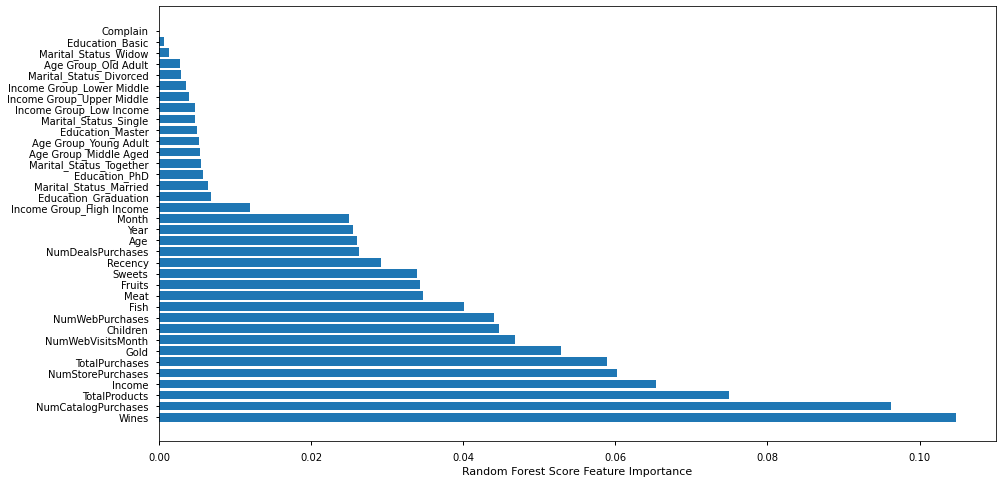

In [ ]:
df_features_imp_RF = pd.DataFrame(features_imp_RF)
df_features_imp_RF.rename(columns={0:'Importance',1:'Features'},inplace=True)
df_features_imp_RF = df_features_imp_RF[['Features','Importance']]

plt.figure(figsize=(15,8))
plt.barh( df_features_imp_RF['Features'],df_features_imp_RF['Importance'])
plt.xlabel("Random Forest Score Feature Importance")

###XGBoost

In [ ]:
#Define classifier
xgb_clf = xgb.XGBClassifier()

#ImbPipeline with SMOTE
pipeline_xgb = imbpipeline(steps = [('preprocessor',preprocess_tfm),
                                   ('smote', SMOTE(random_state=42)),
                                   ('clf', xgb_clf)])

In [ ]:
pipeline_xgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessing',
                                                  MinMaxScaler(),
                                                  ['Age', 'Income', 'Recency',
                                                   'Wines', 'Fruits', 'Meat',
                                                   'Fish', 'Sweets', 'Gold',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Complain', 'Children',
                                                   'Month', 'Year',
                                 

In [ ]:
# Predict training data
y_train_xgb = pipeline_xgb.predict(X_train)
# Accuracy on train set
print(f"Predictions on training data: {roc_auc_score(y_train,y_train_xgb)}")

# Predict test data
y_test_xgb = pipeline_xgb.predict(X_test)
# Accuracy on test set
print(f"Predictions on test data: {roc_auc_score(y_test,y_test_xgb)}")

Predictions on training data: 0.8432377914430702
Predictions on test data: 0.7263242864540498


In [ ]:
pipeline_xgb.named_steps

{'clf': XGBClassifier(),
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('num_preprocessing', MinMaxScaler(),
                                  ['Age', 'Income', 'Recency', 'Wines', 'Fruits',
                                   'Meat', 'Fish', 'Sweets', 'Gold',
                                   'NumDealsPurchases', 'NumWebPurchases',
                                   'NumCatalogPurchases', 'NumStorePurchases',
                                   'NumWebVisitsMonth', 'Complain', 'Children',
                                   'Month', 'Year', 'TotalPurchases',
                                   'TotalProducts']),
                                 ('cat_preprocessing',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['Education', 'Age Group', 'Marital_Status',
                                   'Income Group'])]),
 'smote': 

#### Randomized Search CV

In [ ]:
pipeline_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num_preprocessing', 'preprocessor__cat_preprocessing', 'preprocessor__num_preprocessing__clip', 'preprocessor__num_preprocessing__copy', 'preprocessor__num_preprocessing__feature_range', 'preprocessor__cat_preprocessing__categories', 'preprocessor__cat_preprocessing__drop', 'preprocessor__cat_preprocessing__dtype', 'preprocessor__cat_preprocessing__handle_unknown', 'preprocessor__cat_preprocessing__sparse', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'clf__base_score', 'clf__booster', 'clf__colsample_bylevel', 'clf__colsample_bynode', 'clf__colsample_bytree', 'clf__gamma', 'clf__learning_rate', 'clf__max_delta_step', 'clf__max_depth', 'cl

In [ ]:
#Randomized Search CV for XGBoost

n_estimators = [int(x) for x in np.linspace(3,100,15)]

max_depth = [int(x) for x in np.linspace(7, 50, 12)]

xgb_random_grid = {'clf__n_estimators': n_estimators,
                    'clf__max_depth' : max_depth,
                    'clf__learning_rate' : np.linspace(0,0.5,12),
                    'clf__gamma':[0.1,0.25,0.5],
                   'clf__min_child_weight': [1,2,3,4,5]}

print(xgb_random_grid)

{'clf__n_estimators': [3, 9, 16, 23, 30, 37, 44, 51, 58, 65, 72, 79, 86, 93, 100], 'clf__max_depth': [7, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50], 'clf__learning_rate': array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181818,
       0.22727273, 0.27272727, 0.31818182, 0.36363636, 0.40909091,
       0.45454545, 0.5       ]), 'clf__gamma': [0.1, 0.25, 0.5], 'clf__min_child_weight': [1, 2, 3, 4, 5]}


In [ ]:
xgb_randSearchCV = RandomizedSearchCV(estimator=pipeline_xgb,
                                        param_distributions=xgb_random_grid,
                                        scoring="roc_auc",
                                        cv = stratified_kfold,
                                        n_iter=20,
                                        n_jobs = -1, verbose = 2)
xgb_randSearchCV.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_preprocessing',
                                                                               MinMaxScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Recency',
                                                                                'Wines',
                                                                                'Fruits',
                                                                                'Meat',
                                     

In [ ]:
#1 ROC - AUC Score
print(xgb_randSearchCV.best_params_)

{'clf__n_estimators': 240, 'clf__max_depth': 100, 'clf__learning_rate': 0.36363636363636365}


In [ ]:
#2 ROC - AUC Score
print(xgb_randSearchCV.best_params_)


{'clf__n_estimators': 65, 'clf__min_child_weight': 4, 'clf__max_depth': 14, 'clf__learning_rate': 0.09090909090909091, 'clf__gamma': 0.25}


####Grid Search CV

#####ROC_AUC

In [ ]:
# Grid Search CV for XGBoost - using ROC_AUC
xgb_param_grid = {"clf__n_estimators" : [int(x) for x in np.linspace(50,100,8)],
                  "clf__max_depth" :  [int(x) for x in np.linspace(10,30,8)],
                  'clf__learning_rate' : np.linspace(0.01,0.1,8),
                  'clf__min_child_weight': [4],
                  'clf__gamma':[0.25]}

xgb_GSC = GridSearchCV(pipeline_xgb,
                       param_grid = xgb_param_grid,
                       scoring = "roc_auc",
                       cv = stratified_kfold,
                       n_jobs=-1, verbose=2)

xgb_GSC.fit(X_train,y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_preprocessing',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Income',
                                                                          'Recency',
                                                                          'Wines',
                                                                          'Fruits',
                                                                          'Meat',
                                                                          'Fish',
                     

In [ ]:
print(xgb_GSC.best_params_)

In [ ]:
#Get back the best_estimator
best_estimator_XGB = xgb_GSC.best_estimator_
# Predict training data
y_train_pred5 = best_estimator_XGB.predict(X_train)
# Score on train set
print(f"Predictions on training data: {roc_auc_score(y_train,y_train_pred5)}")

# Predict test data
y_test_pred5 = best_estimator_XGB.predict(X_test)
# Score on test set
print(f"Predictions on test data: {roc_auc_score(y_test,y_test_pred5)}")

Predictions on training data: 0.9830316221009237
Predictions on test data: 0.7608669164458254


In [ ]:
some_data = X_test.iloc[390:400]
some_labels = y_test[390:400]

print("Predictions: ", best_estimator_XGB.predict(some_data))
print("Labels: ", some_labels)

Predictions:  [1 1 0 0 0 0 0 1 0 0]
Labels:  [[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]


####Save & load model

In [ ]:
import pickle
# save the model to disk
filename = '/content/gdrive/MyDrive/DATASET/Final_Project_MLE/SAVED_MODEL/ROCAUC_XGB_p2.sav'
pickle.dump(best_estimator_XGB, open(filename, 'wb'))

In [ ]:
import pickle
# load the model from disk
filename = '/content/gdrive/MyDrive/DATASET/Final_Project_MLE/SAVED_MODEL/ROCAUC_XGB_76.sav'

def load_model(filename,X_test, y_test):
    loaded_model = pickle.load(open(filename, 'rb'))
    # Predict test data
    y_test_pred = loaded_model.predict(X_test)
    # Score on test set
    print("Score on test set= {:5.4f}".format(roc_auc_score(y_test,y_test_pred)))
    return loaded_model

In [ ]:
filename = '/content/gdrive/MyDrive/DATASET/Final_Project_MLE/SAVED_MODEL/ROCAUC_XGB_76.sav'
loaded_model = pickle.load(open(filename, 'rb'))

some_data = X_test.iloc[10:20]
some_labels = y_test[10:20]

print("Predictions: ", loaded_model.predict(some_data))
print("Labels: ", some_labels)

Predictions:  [1 0 0 1 0 0 0 0 1 0]
Labels:  [[1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]


In [ ]:
loaded_model.named_steps['clf']

XGBClassifier(learning_rate=0.3333333333333333, max_depth=80, missing=nan,
              n_estimators=400)

####Features Importance

In [ ]:
#Get Features importance score
xgb_feature_importances = best_estimator_XGB['clf'].feature_importances_
#List name of full features
final_features_name = num_features + list(pipeline_xgb.named_steps['preprocessor'].named_transformers_['cat_preprocessing'].get_feature_names_out(cat_features))
# final_features_name

In [ ]:
#Combine full features and their importance scores, sorted
features_imp = sorted(zip(list(xgb_feature_importances),final_features_name),reverse=True)
features_imp[:3]

In [ ]:
df_features_imp = pd.DataFrame(features_imp)
df_features_imp.rename(columns={0:'Importance',1:'Features'},inplace=True)
df_features_imp = df_features_imp[['Features','Importance']]
df_features_imp.head(8)

,Features,Importance
0,Wines,0.12387
1,Children,0.07866
2,Education_Basic,0.07471
3,NumCatalogPurchases,0.07349
4,Age Group_Old Adult,0.07313
5,NumStorePurchases,0.05936
6,NumWebVisitsMonth,0.03331
7,Marital_Status_Divorced,0.03107


Text(0.5, 0, 'Xgboost Feature Importance')

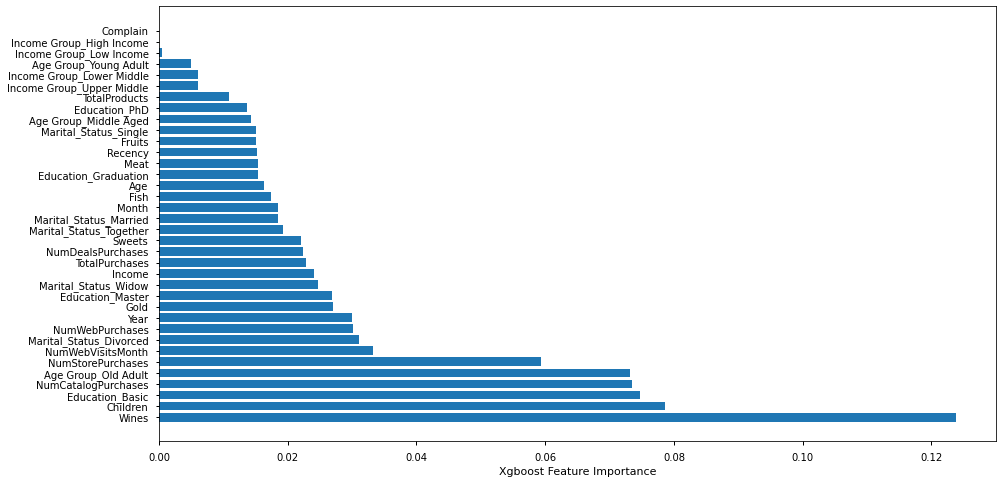

In [ ]:
plt.figure(figsize=(15,8))
plt.barh( df_features_imp['Features'],df_features_imp['Importance'])
plt.xlabel("Xgboost Feature Importance")

So from the barchart above, we can see there are some features that's importance here like: Wines, Children, Education_basic, NumCatalogPurchases,....

###LightGBM

In [ ]:
#define classifier
lgbm_clf = lgb.LGBMClassifier()

#ImbPipeline with SMOTE
pipeline_lgbm = imbpipeline(steps = [('preprocessor',preprocess_tfm),
                                   ('smote', SMOTE(random_state=42)),
                                   ('clf', lgbm_clf)])

In [ ]:
pipeline_lgbm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessing',
                                                  MinMaxScaler(),
                                                  ['Age', 'Income', 'Recency',
                                                   'Wines', 'Fruits', 'Meat',
                                                   'Fish', 'Sweets', 'Gold',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Complain', 'Children',
                                                   'Month', 'Year',
                                 

In [ ]:
# Predict training data
y_train_lgbm = pipeline_lgbm.predict(X_train)
# Accuracy on train set
print(f"Predictions on training data: {roc_auc_score(y_train,y_train_lgbm)}")

# Predict test data
y_test_lgbm = pipeline_lgbm.predict(X_test)
# Accuracy on test set
print(f"Predictions on test data: {roc_auc_score(y_test,y_test_lgbm)}")

Predictions on training data: 1.0
Predictions on test data: 0.7368180572055195


####Randomized Search CV

In [ ]:
#Randomized Search CV for LightGBM
n_estimators = [int(x) for x in np.linspace(50,400,10)]

max_depth = [int(x) for x in np.linspace(3, 100, 10)]

lgbm_random_grid = {'clf__n_estimators': n_estimators,
                    'clf__max_depth' : max_depth,
                    'clf__learning_rate' : np.linspace(0.01,0.5,10)
                    }

print(lgbm_random_grid)

{'clf__n_estimators': [50, 88, 127, 166, 205, 244, 283, 322, 361, 400], 'clf__max_depth': [3, 13, 24, 35, 46, 56, 67, 78, 89, 100], 'clf__learning_rate': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ])}


In [ ]:
lgbm_randSearchCV = RandomizedSearchCV(estimator=pipeline_lgbm,
                                        param_distributions=lgbm_random_grid,
                                        scoring="roc_auc",
                                        cv = stratified_kfold,
                                        n_iter=20,
                                        n_jobs = -1, verbose = 2)
lgbm_randSearchCV.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_preprocessing',
                                                                               MinMaxScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Recency',
                                                                                'Wines',
                                                                                'Fruits',
                                                                                'Meat',
                                     

In [ ]:
print(lgbm_randSearchCV.best_params_)

{'clf__n_estimators': 244, 'clf__max_depth': 78, 'clf__learning_rate': 0.06444444444444444}


####Grid Search CV

In [ ]:
# Grid Search CV for LightGBM
lgbm_param_grid = {"clf__n_estimators" : [int(x) for x in np.linspace(200,300,6)],
                  "clf__max_depth" :  [int(x) for x in np.linspace(50,100,6,endpoint=True)],
                  'clf__learning_rate' : np.linspace(0.001,0.1,6)
                  }

print(lgbm_param_grid)

lgbm_GSC = GridSearchCV(pipeline_lgbm,
                       param_grid = lgbm_param_grid,
                       scoring = "roc_auc",
                       cv = stratified_kfold,
                       n_jobs=-1, verbose=2)

lgbm_GSC.fit(X_train,y_train)

{'clf__n_estimators': [200, 220, 240, 260, 280, 300], 'clf__max_depth': [50, 60, 70, 80, 90, 100], 'clf__learning_rate': array([0.001 , 0.0208, 0.0406, 0.0604, 0.0802, 0.1   ])}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_preprocessing',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Income',
                                                                          'Recency',
                                                                          'Wines',
                                                                          'Fruits',
                                                                          'Meat',
                                                                          'Fish',
                     

In [ ]:
print(lgbm_GSC.best_params_)

{'clf__learning_rate': 0.040600000000000004, 'clf__max_depth': 50, 'clf__n_estimators': 240}


In [ ]:
#Get back the best_estimator
best_estimator_LGBM = lgbm_GSC.best_estimator_
# Predict training data
y_train_pred4 = best_estimator_LGBM.predict(X_train)
# Accuracy on train set
print(f"Predictions on training data: {roc_auc_score(y_train,y_train_pred4)}")

# Predict test data
y_test_pred4 = best_estimator_LGBM.predict(X_test)
# Accuracy on test set
print(f"Predictions on test data: {roc_auc_score(y_test,y_test_pred4)}")

Predictions on training data: 1.0
Predictions on test data: 0.7342745743092998


####Save & load model

In [ ]:
import pickle
# save the model to disk
filename = '/content/gdrive/MyDrive/DATASET/Final_Project_MLE/SAVED_MODEL/ROC_AUC_LGBM_734.sav'
pickle.dump(best_estimator_LGBM, open(filename, 'wb'))

In [ ]:
# load the model from disk
model_LGBM = '/content/gdrive/MyDrive/DATASET/Final_Project_MLE/SAVED_MODEL/ROC_AUC_LGBM_734.sav'

def load_model(filename,X_test, y_test):
    loaded_model = pickle.load(open(model_LGBM, 'rb'))
    # Predict div data
    y_test_pred = loaded_model.predict(X_test)
    # Score on test set
    print("Score on test set= {:5.4f}".format(roc_auc_score(y_test,y_test_pred)))
    # return loaded_model

In [ ]:
load_model(model_LGBM,X_test,y_test)

Score on test set= 0.7343
